In [1]:
# Import des modules libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

In [6]:
# Pipeline n°01 : Junior pipeline of death

def Titanic_pipeline(df):
    Titanic_clean = df.drop(['Cabin'], axis=1)

    # Dummies for sex
    Titanic_sex = pd.Series(Titanic_clean['Sex'])
    Sex_dummies = pd.get_dummies(Titanic_sex)
    Titanic_clean = Titanic_clean.merge(Sex_dummies, left_index=True, right_index=True)

    # Dummies for Embarked
    Titanic_clean['Embarked'].fillna(value='S', inplace=True)
    Titanic_Emb = pd.Series(Titanic_clean['Embarked'])
    Emb_dummies = pd.get_dummies(Titanic_Emb, prefix='Emb')
    Titanic_clean = Titanic_clean.merge(Emb_dummies, left_index=True, right_index=True)

    # Interval and Dummies for Age
    Titanic_clean['Age'].fillna(value=Titanic_clean['Age'].mean(), inplace=True)
    Titanic_AgeCut = pd.cut(Titanic_clean['Age'], 5)
    AgeCut_dummies = pd.get_dummies(Titanic_AgeCut)
    AgeCut_Intervals = AgeCut_dummies.columns
    AgeCut_dummies.columns = ['Age_'+str(i+1) for i in range(5)] # Renaming cols to make manipulation easier
    Titanic_clean = Titanic_clean.merge(AgeCut_dummies, left_index=True, right_index=True)

    # Interval and Dummies for Fare
    Titanic_FareCut = pd.cut(Titanic_clean['Fare'], 5)
    FareCut_dummies = pd.get_dummies(Titanic_FareCut)
    FareCut_Intervals = FareCut_dummies.columns
    FareCut_dummies.columns = ['Fare_'+str(i+1) for i in range(5)] # Renaming cols to make manipulation easier
    Titanic_clean = Titanic_clean.merge(FareCut_dummies, left_index=True, right_index=True)    
    
    # Make the training set
    Titanic = Titanic_clean[['female', 'male', 'Emb_C', 'Emb_Q', 'Emb_S',
                                    'Age_1', 'Age_2', 'Age_3', 'Age_4', 'Age_5',
                            'Fare_1', 'Fare_2', 'Fare_3', 'Fare_4', 'Fare_5']]
    
    # Extract first column, should be 'Survived' for Training set
    if('Survived' in Titanic_clean.columns):
        First_Col = Titanic_clean['Survived']
    else:
        First_Col = Titanic_clean[Titanic_clean.columns[0]]
    
    return Titanic, First_Col

In [7]:
# Load both datasets

# Training set
Titanic_train_raw = pd.read_csv('train.csv')

# Testing set
Titanic_test_raw = pd.read_csv('test.csv')

In [8]:
# Use the piepline function to make the datasets for the machine learning part

# Training set
Titanic_train, Y_train = Titanic_pipeline(Titanic_train_raw)

# Testing set
Titanic_test, Trash = Titanic_pipeline(Titanic_test_raw)

# /!\ CAUTION : 'Survived' column is in both datasets, be aware of that when you will be fitting the model.

In [9]:
# Machine Learning - Use of the KNN, K = 3

knn = KNeighborsClassifier(3)

In [10]:
# Fitting the model

knn.fit(Titanic_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [11]:
# Make the prediction !

Y_test_pred = knn.predict(Titanic_test)

In [12]:
# Merge prediction and Passenger ID and save it as .csv file

Pred_output = pd.DataFrame(Trash) # Make a DataFrame out of the passenger ID
Pred_output['Survived'] = Y_test_pred # Add the prediction for each passenger

# Save the data frame into a .csv file !
Pred_output.to_csv('KyllianBeguin_KaggleCompetition_TitanicSurvival.csv', index=False)

In [21]:
# GRAPHICS
# List of all the graphs :
# - NAs of all training set columns, to justify the drop of 'Cabin' before permorfing .dropna() function
# - Counts for the used variables (pipelined data sets) for training set
# - Counts for the used variables (pipelined data sets) for testing set (with predicted number of people that survived)
# - Number of people that survived vs died (prediction)


# Add the 'Survived' column to the pieplined data sets (training and testing sets)
Titanic_test.insert(0, 'Survived', Y_test_pred) # Prediction

Titanic_train.insert(0, 'Survived', Y_train) # Real results from the training set (The second ouput of the piepline function)

In [22]:
# Functions used for graphs

def Na_Evaluation(df):
    Na_Eval_List = []
    for i in range(len(df.columns)):
        Num = df[df.columns[i]].isna().sum()
        Na_Eval_List.append(Num)
    return Na_Eval_List

def Put_labels(ax, label):
    rects = ax.patches # Access to the bars, in order to get height and width
    for rect, label in zip(rects, label): # Place the labels
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom')

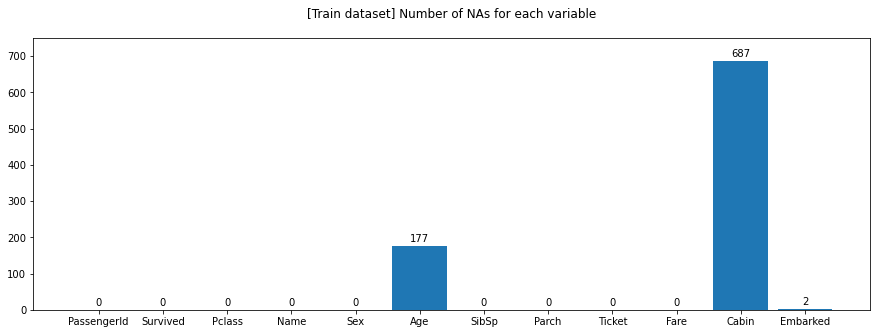

In [23]:
# [Graph 01]
# __Number of NAs by column__


Nas_RAW = Na_Evaluation(Titanic_train_raw) # Number of the Nas for each column
Col_Names_Titanic = list(Titanic_train_raw.columns) # Names of the columns for the RAW datasets
Col_Numbers_Titanic = np.arange(len(Col_Names_Titanic)) # List of integers to setup the bar chart

# Graphic of the output from the Na_Evaluation function
fig, ax = plt.subplots(figsize = (15,5))
ax.bar(Col_Numbers_Titanic, Nas_RAW, 0.85) # The bar plot

ax.set_xticks(Col_Numbers_Titanic) # Ticks to each integer from the function
ax.set_xticklabels(Col_Names_Titanic) # Label each tick with the column's name

Put_labels(ax, Nas_RAW)
    
plt.ylim([0, 750])

plt.title('[Train dataset] Number of NAs for each variable\n')

plt.show()

# 'Cabin' and 'Age' have a lot of NAs.
# performing a dropna() will loose a lot of information.
# By removing the 'Cabin' column, I wont loose more than 177+2 rows ('Age'+'Embarked').
# This is better than possibly loosing 687 more rows from 'Cabin'.

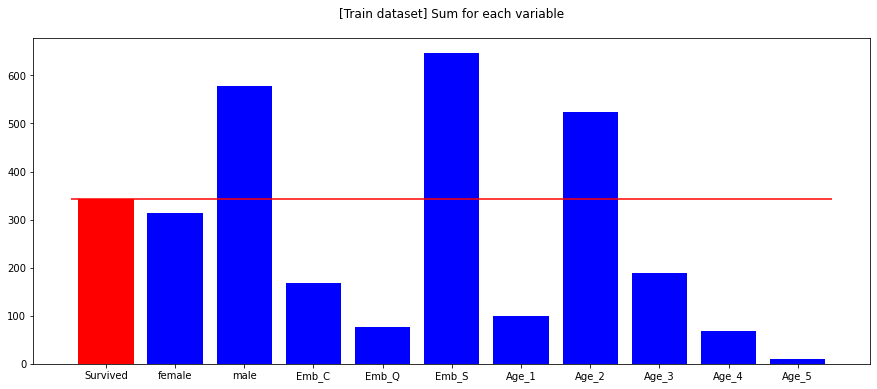

In [24]:
# [Graph 02]
# Overview of the variables : Counts for train data set

fig, ax = plt.subplots(figsize=(15,6))

x = np.arange(len(Titanic_train.columns))
Sum_cols = [Titanic_train[Titanic_train.columns[i]].sum() for i in range(len(Titanic_train.columns))]

red = ['r']
blues = ['b' for i in range(len(Titanic_train.columns)-1)]

rect = ax.bar(x, Sum_cols, color=red+blues)
ax.set_xticks(x)
ax.set_xticklabels(Titanic_train.columns)
ax.hlines(Sum_cols[0], -0.5, len(Sum_cols)-0.5, color='r')

plt.title('[Train dataset] Sum for each variable\n')

plt.show()

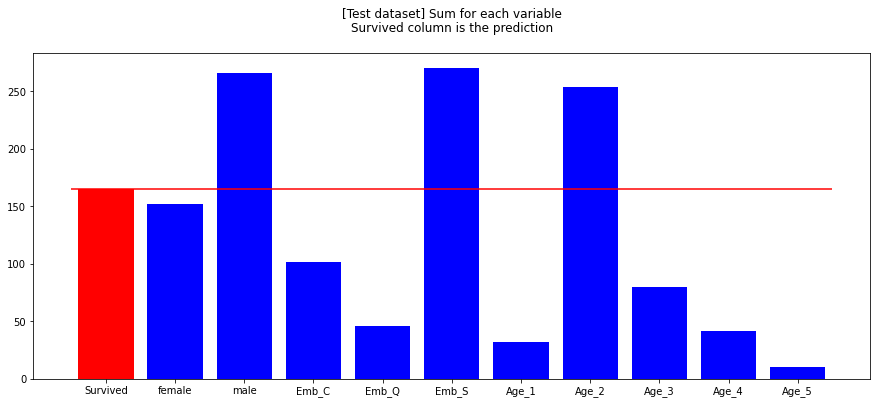

In [25]:
# [Graph 03]
# Overview of the variables : Counts for test data set

fig, ax = plt.subplots(figsize=(15,6))

x = np.arange(len(Titanic_test.columns))
Sum_cols = [Titanic_test[Titanic_test.columns[i]].sum() for i in range(len(Titanic_test.columns))]

red = ['r']
blues = ['b' for i in range(len(Titanic_test.columns)-1)]

rect = ax.bar(x, Sum_cols, color=red+blues)
ax.set_xticks(x)
ax.set_xticklabels(Titanic_train.columns)
ax.hlines(Sum_cols[0], -0.5, len(Sum_cols)-0.5, color='r')

plt.title('[Test dataset] Sum for each variable\nSurvived column is the prediction\n')

plt.show()

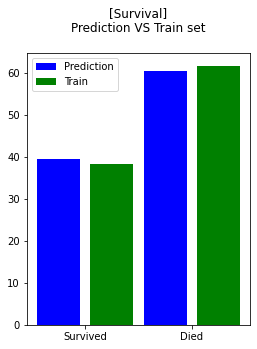

In [26]:
# [Graph 04]
# Survival %: Prediction vs Train data

# Dataframe of predictions
df01 = pd.DataFrame()
df01['Passenger_ID'] = Trash
df01['Survived_Pred'] = Y_test_pred
df01['Not_Survived_Pred'] = [1 if Y_test_pred[i] == 0 else 0 for i in range(len(Y_test_pred))]

# Dataframe of train survival data
df02 = pd.DataFrame()
df02['Survived_Train'] = Y_train
df02['Not_Survived_Train'] = [1 if list(Y_train)[i] == 0 else 0 for i in range(len(Y_train))]

fig, ax = plt.subplots(figsize=(4,5))

x = np.arange(4)
x_ticks = [0.5, 2.5]

# List of the percentage of survivability for each set
Sum_cols = [((df01[df01.columns[1]].sum())/(df01[df01.columns[1]].sum()+df01[df01.columns[2]].sum()))*100,
            ((df02[df02.columns[0]].sum())/(df02[df02.columns[0]].sum()+df02[df02.columns[1]].sum()))*100,
            ((df01[df01.columns[2]].sum())/(df01[df01.columns[1]].sum()+df01[df01.columns[2]].sum()))*100,
           ((df02[df02.columns[1]].sum())/(df02[df02.columns[0]].sum()+df02[df02.columns[1]].sum()))*100]
colors = ['b', 'g', 'b', 'g']


rect = ax.bar(x, Sum_cols, color=colors)
ax.set_xticks(x_ticks)
ax.set_xticklabels(['Survived', 'Died'])

ax.legend((rect), ('Prediction', 'Train'))

plt.title('[Survival]\nPrediction VS Train set\n')

plt.show()